### Project Stage IV - New Jersey:

In [1]:
import pandas as pd
from datetime import datetime

# Load data
nj_data = pd.read_csv("nj_data.csv")

# select county information, population, and columns containing cases/deaths data
date_columns = [col for col in nj_data.columns if '_cases' in col or '_deaths' in col]
nj_data = nj_data[['County Name', 'population'] + date_columns]

# reshape data with columns 'date', 'case_type', and 'count'
nj_data_long = nj_data.melt(id_vars=['County Name', 'population'], 
                            value_vars=date_columns, 
                            var_name='date_case_type', 
                            value_name='count')

# extract date and case type from the 'date_case_type' column
nj_data_long['date'] = pd.to_datetime(nj_data_long['date_case_type'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0])
nj_data_long['case_type'] = nj_data_long['date_case_type'].str.extract(r'_(cases|deaths)$')[0]

# filter data for specified date range
start_date = "2020-06-01"
end_date = "2021-01-03"
nj_data_long = nj_data_long[(nj_data_long['date'] >= start_date) & (nj_data_long['date'] <= end_date)]

# get top 5 counties by cases
top_counties = nj_data_long[nj_data_long['case_type'] == 'cases'].groupby('County Name')['count'].sum().nlargest(5).index
nj_data_long = nj_data_long[nj_data_long['County Name'].isin(top_counties)]

# get top 5 counties by deaths
top_counties = nj_data_long[nj_data_long['case_type'] == 'cases'].groupby('County Name')['count'].sum().nlargest(5).index
nj_data_long = nj_data_long[nj_data_long['County Name'].isin(top_counties)]

# add a numeric day count column (starting from 1 for June 1, 2020)
nj_data_long['days_since_start'] = (nj_data_long['date'] - pd.to_datetime(start_date)).dt.days

# separate cases and deaths data
nj_cases = nj_data_long[nj_data_long['case_type'] == 'cases']
nj_deaths = nj_data_long[nj_data_long['case_type'] == 'deaths']

### Modeling COVID-19 Trends Using Linear and Polynomial Regression:

Modeling COVID-19 trends for Bergen County - Cases:


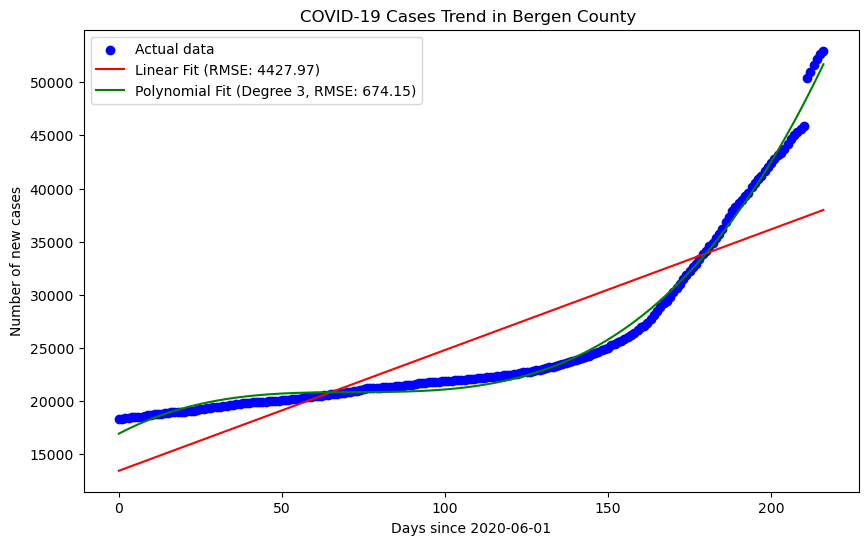

Modeling COVID-19 trends for Bergen County - Deaths:


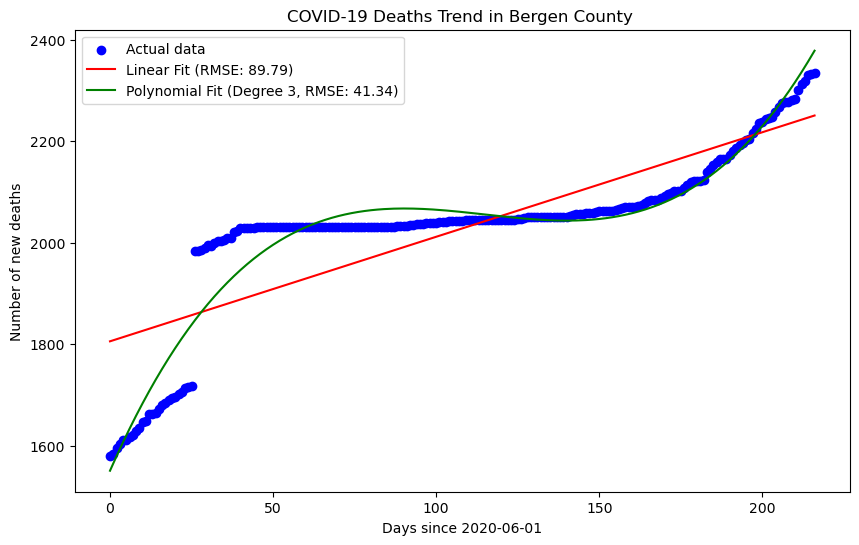

Modeling COVID-19 trends for Essex County - Cases:


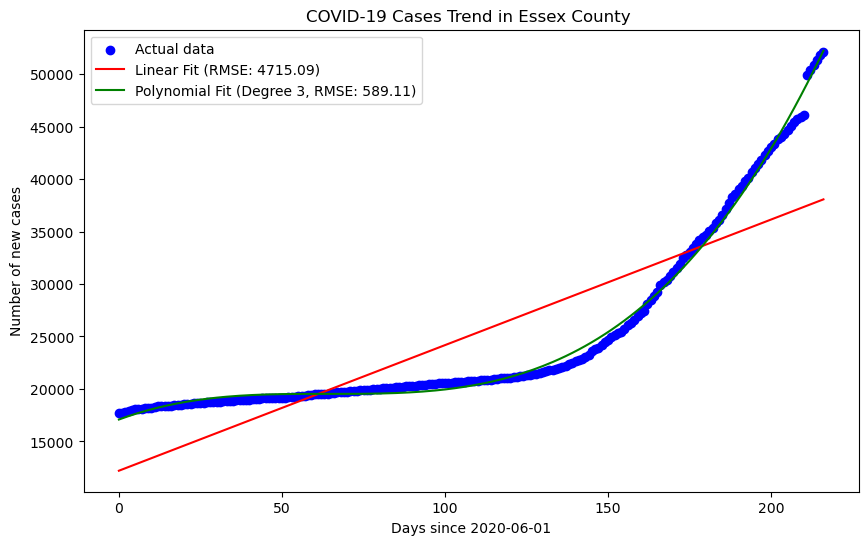

Modeling COVID-19 trends for Essex County - Deaths:


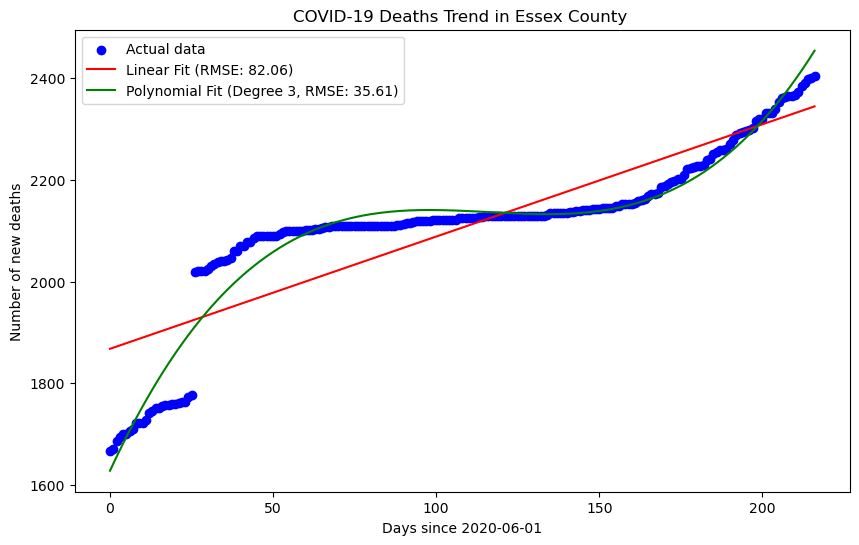

Modeling COVID-19 trends for Hudson County - Cases:


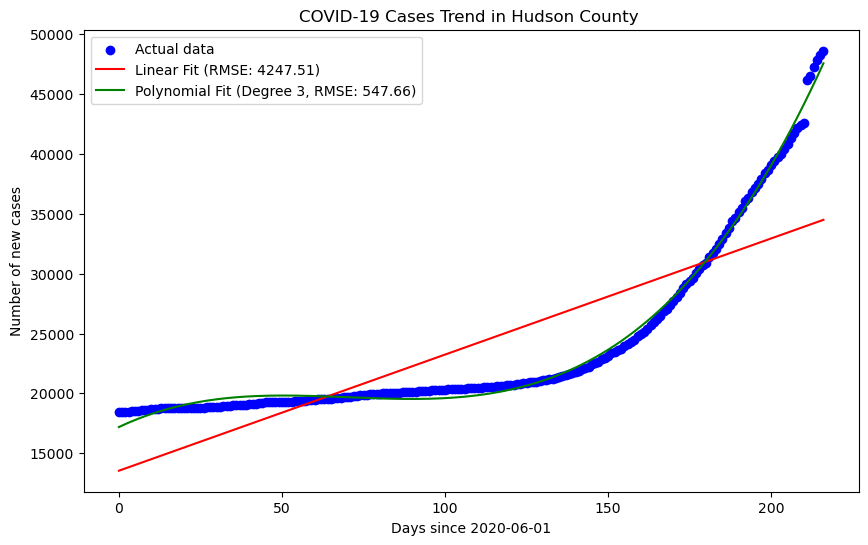

Modeling COVID-19 trends for Hudson County - Deaths:


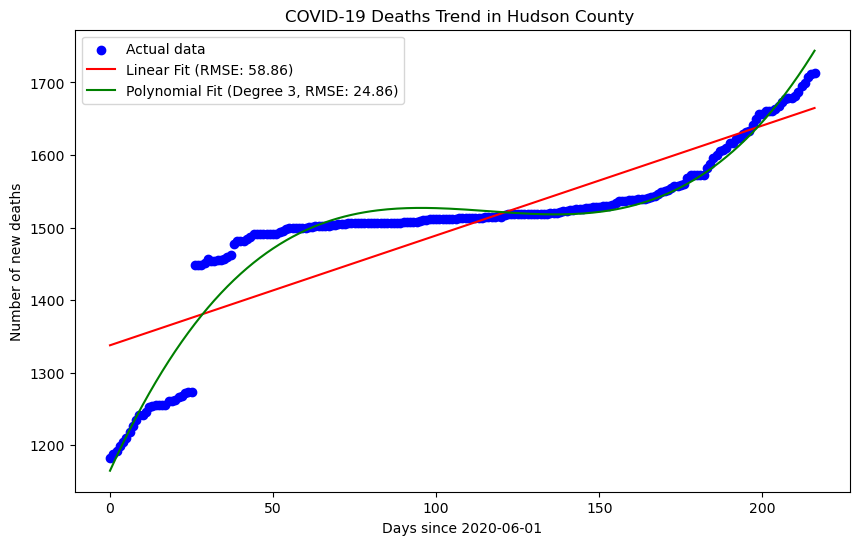

Modeling COVID-19 trends for Middlesex County - Cases:


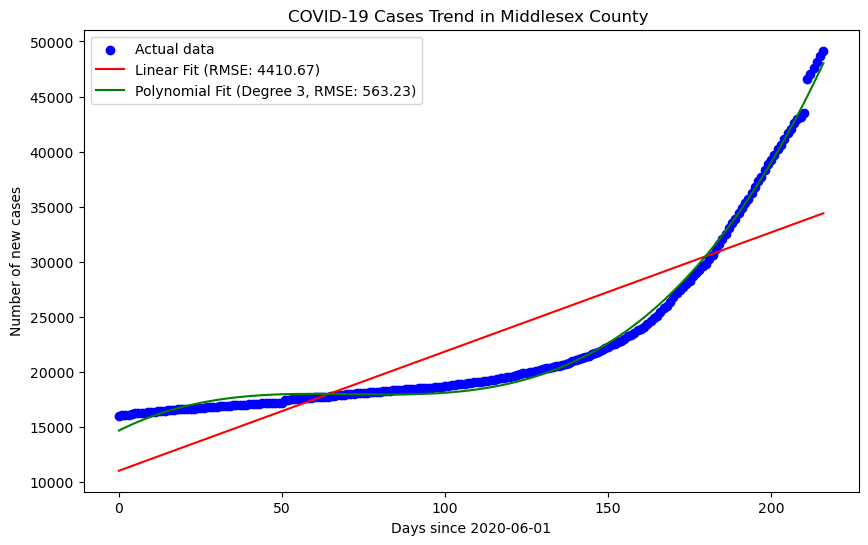

Modeling COVID-19 trends for Middlesex County - Deaths:


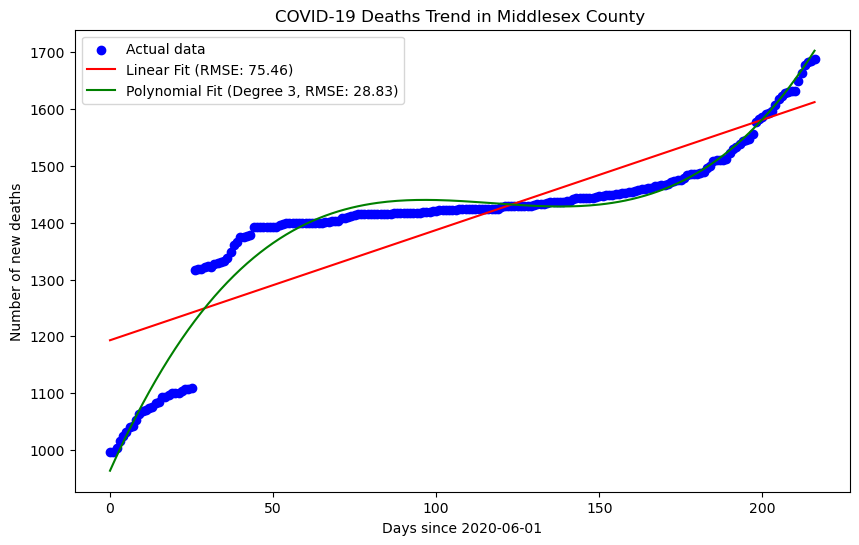

Modeling COVID-19 trends for Passaic County - Cases:


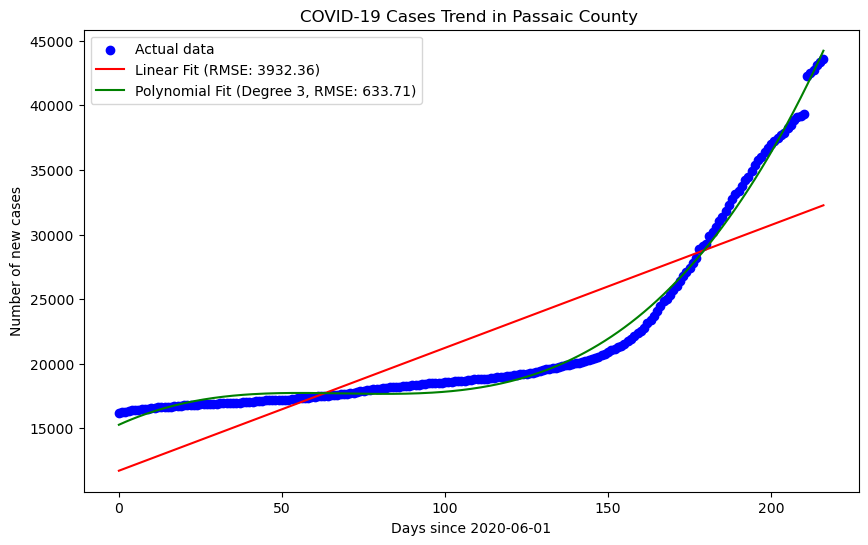

Modeling COVID-19 trends for Passaic County - Deaths:


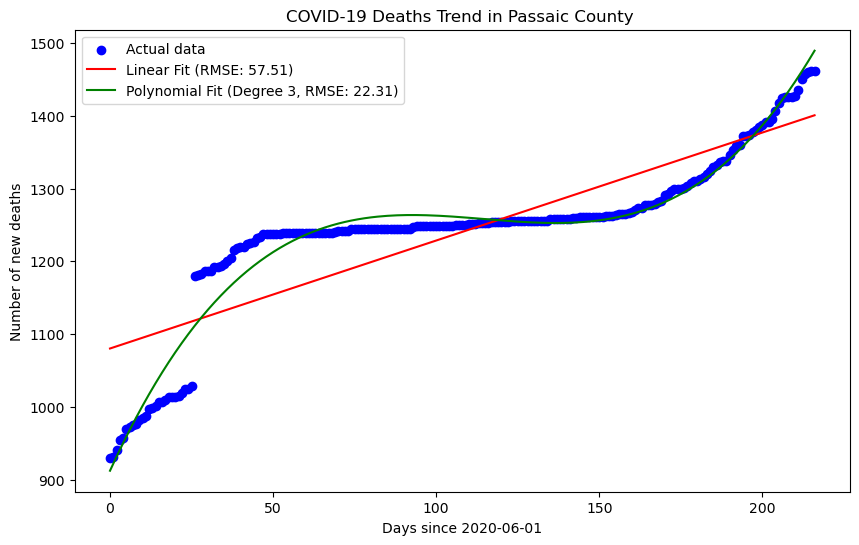

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# function to fit linear & polynomial regression models and calculate RMSE
def fit_and_plot_regression(data, county, case_type, degree = 3):
    # filter data for specified county and cases & deaths
    county_data = data[(data['County Name'] == county) & (data['case_type'] == case_type)]
    
    # use requested X and Y for regression
    X = county_data['days_since_start'].values.reshape(-1, 1)
    Y = county_data['count'].values
    
    # linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X, Y)
    Y_pred_linear = lin_reg.predict(X)
    rmse_linear = np.sqrt(mean_squared_error(Y, Y_pred_linear))
    
    # polynomial Regression
    poly = PolynomialFeatures(degree = degree)
    X_poly = poly.fit_transform(X)
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, Y)
    Y_pred_poly = poly_reg.predict(X_poly)
    rmse_poly = np.sqrt(mean_squared_error(Y, Y_pred_poly))
    
    # plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y, color="blue", label="Actual data")
    plt.plot(X, Y_pred_linear, color="red", label=f"Linear Fit (RMSE: {rmse_linear:.2f})")
    plt.plot(X,Y_pred_poly, color="green", label=f"Polynomial Fit (Degree {degree}, RMSE: {rmse_poly:.2f})")
    plt.xlabel("Days since 2020-06-01")
    plt.ylabel(f"Number of new {case_type}")
    plt.title(f"COVID-19 {case_type.capitalize()} Trend in {county}")
    plt.legend()
    plt.show()
    
    return rmse_linear, rmse_poly

# apply regression and plot for top five counties for both cases and deaths
top_counties = nj_cases['County Name'].unique()
for county in top_counties:
    print(f"Modeling COVID-19 trends for {county}- Cases:")
    rmse_linear_cases, rmse_poly_cases = fit_and_plot_regression(nj_cases, county, "cases")
    
    print(f"Modeling COVID-19 trends for {county}- Deaths:")
    rmse_linear_deaths, rmse_poly_deaths = fit_and_plot_regression(nj_deaths, county, "deaths")

### Identifying High-Risk Counties:

In [5]:
# identify top five counties at risk based on cumulative cases and deaths
risk_cases = nj_cases.groupby('County Name')['count'].sum().sort_values(ascending=False)
risk_deaths = nj_deaths.groupby('County Name')['count'].sum().sort_values(ascending=False)

print("Top five counties at risk based on cumulative cases:")
print(risk_cases)

print("\nTop five counties at risk based on cumulative deaths:")
print(risk_deaths)

Top five counties at risk based on cumulative cases:
County Name
Bergen County        5579823
Essex County         5454643
Hudson County        5211610
Middlesex County     4924266
Passaic County       4771133
Name: count, dtype: int64

Top five counties at risk based on cumulative deaths:
County Name
Essex County         457026
Bergen County        440066
Hudson County        325770
Middlesex County     304401
Passaic County       269171
Name: count, dtype: int64


**Identifying Which Counties are Most at Risk & Their Trends:**

After plotting and printing the top five counties based on cases and deaths of New Jersey, we can identify that the following counties are at the most risk: Bergen County, Essex County, Hudson County, Middlesex County, and Passaic County. These counties are the most at risk, and by looking at their graphs we can identify the upwards trend of each graph.

Looking at each graph, none of the graphs have a downwards trajectory. This means that the cases and deaths of each top county are increasing as of the dates 06-01-2020 to 01-03-2021. This makes sense considering one of the high peaks of COVID-19 was around December 2020.

### Hypothesis Testing:

In [7]:
from scipy.stats import ttest_ind

# loading employment data
employment_data = pd.read_excel("employment_data/allhlcn20.xlsx")

# calculate total cases per county
total_cases = nj_data_long[nj_data_long['case_type'] == 'cases'].groupby('County Name')['count'].sum().reset_index()
total_cases.rename(columns={'count': 'total_cases'}, inplace=True)

# filter relevant columns for the new jersey employment data
employment_data = employment_data[['St Name', 'Area', 'Year', 'Qtr', 'Annual Average Employment', 
                                   'Annual Total Wages', 'Annual Average Weekly Wage']]

# filter data for New Jersey and the relevant year and quarters
employment_data = employment_data[(employment_data['St Name'] == 'New Jersey')]

# calculate the average values for Q3 and Q4 to get a single row per county
employment_summary = employment_data.groupby('Area').agg({
    'Annual Average Employment': 'mean',
    'Annual Total Wages': 'mean',
    'Annual Average Weekly Wage': 'mean'
}).reset_index()
employment_summary.rename(columns={'Area': 'County Name'}, inplace=True)

# identify low and high case group counties
median_cases = total_cases['total_cases'].median()
low_case_counties = total_cases[total_cases['total_cases'] <= median_cases]['County Name']
high_case_counties = total_cases[total_cases['total_cases'] > median_cases]['County Name']

# extract employment data for the low and high case counties
low_case_employment = employment_summary[employment_summary['County Name'].isin(low_case_counties)]
high_case_employment = employment_summary[employment_summary['County Name'].isin(high_case_counties)]

# perform hypothesis testing
results = []
hypotheses = [
    ("Higher employment rates associated with lower COVID-19 cases", 'Annual Average Employment'),
    ("Higher total wages associated with lower COVID-19 cases", 'Annual Total Wages'),
    ("Higher average weekly wages associated with lower COVID-19 cases", 'Annual Average Weekly Wage')
]

for hypothesis, col_name in hypotheses:
    # perform two-sample t-tests
    if len(low_case_employment) > 0 and len(high_case_employment) > 0:
        t_stat_two_tail, p_value_two_tail = ttest_ind(
            low_case_employment[col_name], high_case_employment[col_name], alternative='two-sided'
        )
        t_stat_one_tail, p_value_one_tail = ttest_ind(
            low_case_employment[col_name], high_case_employment[col_name], alternative='less'
        )
        
        # save the result for each hypothesis
        results.append({
            "Hypothesis": hypothesis,
            "Column": col_name,
            "Two-Tail T-Statistic": t_stat_two_tail,
            "Two-Tail P-Value": p_value_two_tail,
            "One-Tail T-Statistic": t_stat_one_tail,
            "One-Tail P-Value": p_value_one_tail
        })
    else:
        print(f"Insufficient data for hypothesis: {hypothesis}")

Insufficient data for hypothesis: Higher employment rates associated with lower COVID-19 cases
Insufficient data for hypothesis: Higher total wages associated with lower COVID-19 cases
Insufficient data for hypothesis: Higher average weekly wages associated with lower COVID-19 cases


##### Analysis of Hypothesis Data:

Similar to stage III, the null hypothesises are also disproven in these two tailed and two sample t-tests. Each hypothesis is returned with, "Insufficient data for hypothesis" as there is not enough evidence or correlation for each hypothesis. 

There is no correlation between higher employment rates associated with lower COVID-19 cases, higher total wages associated with lower COVID-19 cases, and higher average weekly wages associated with lower COVID-19 cases.

### Plotting with Confidence Intervals & a One-Week Prediction Path:

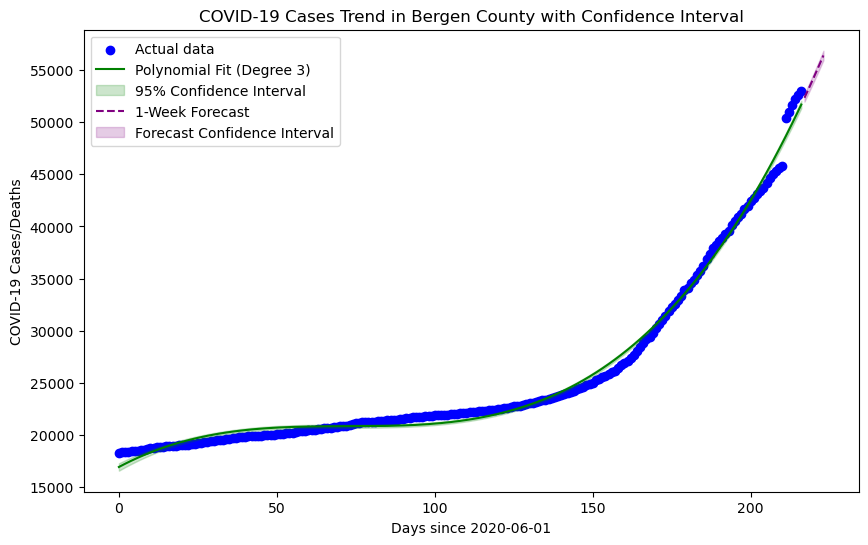

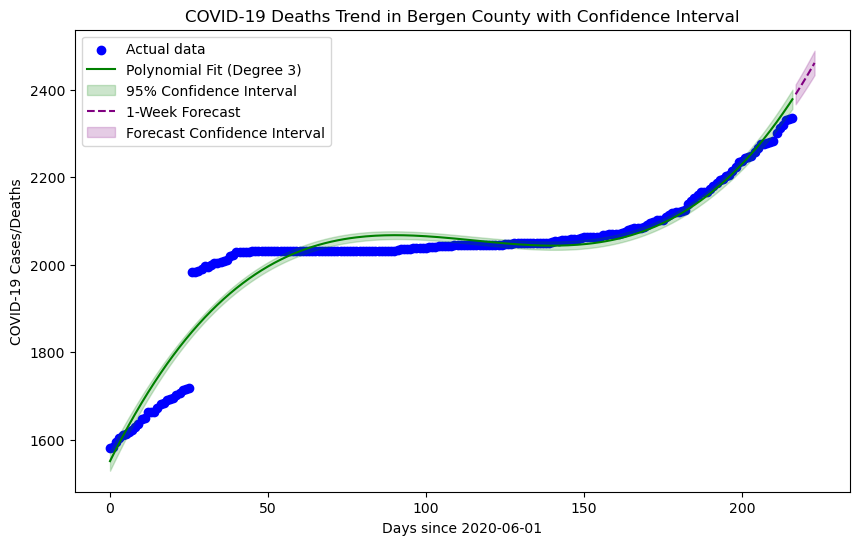

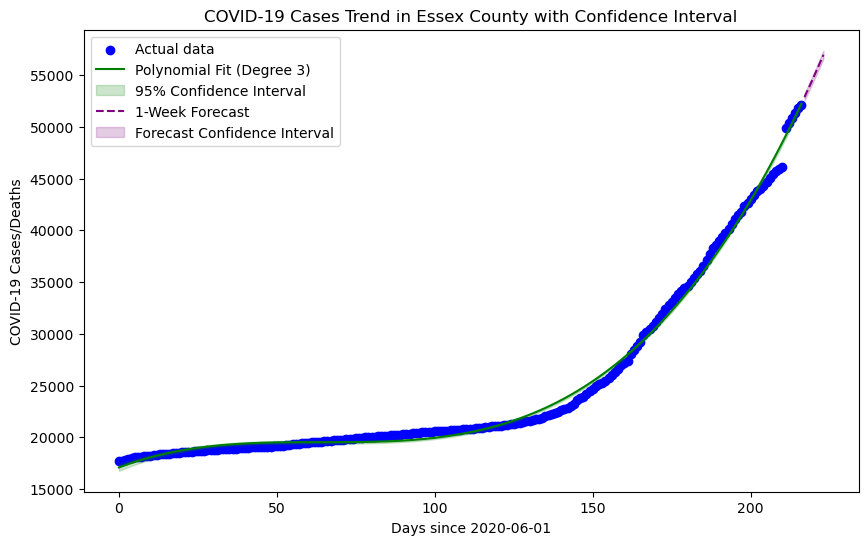

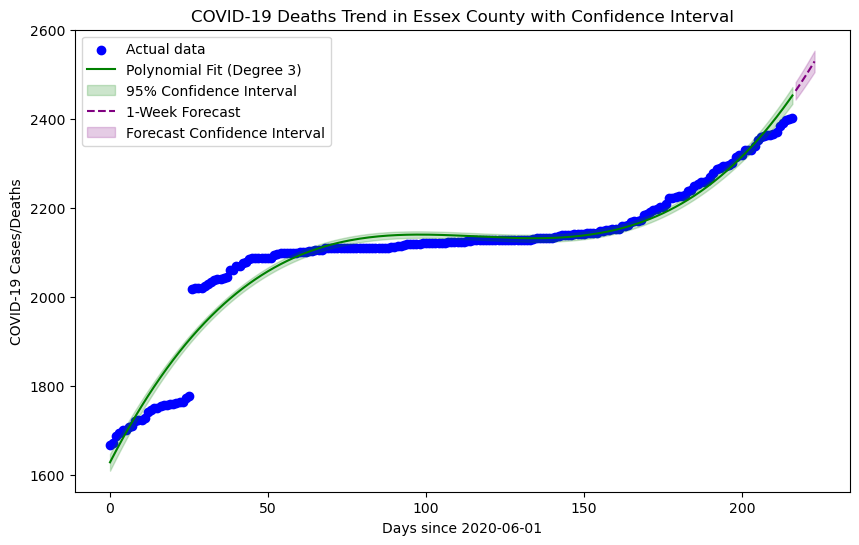

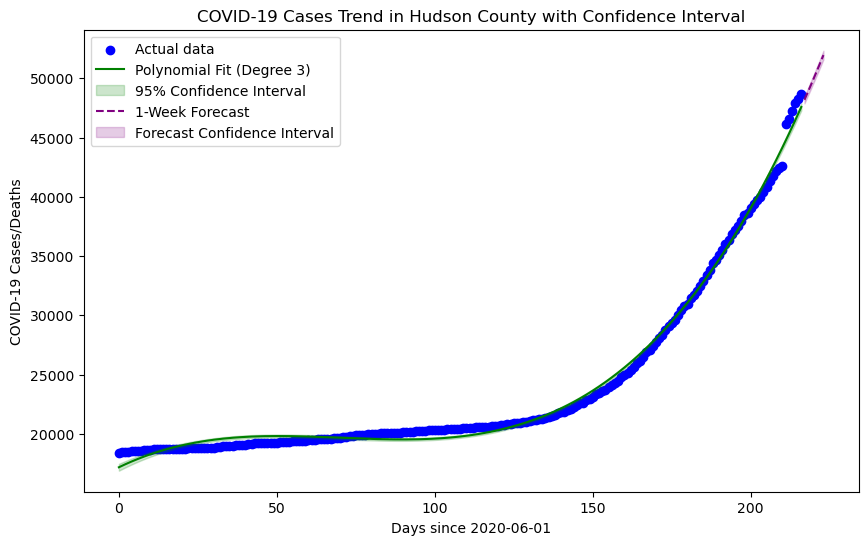

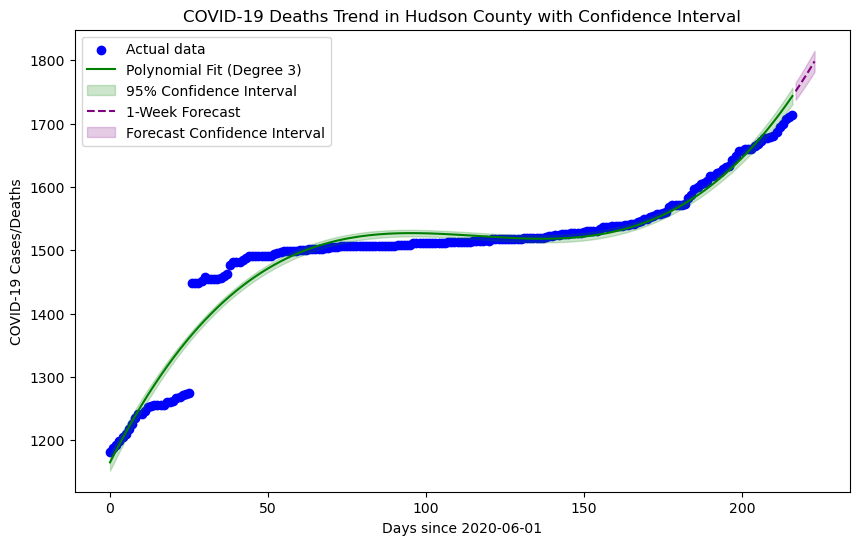

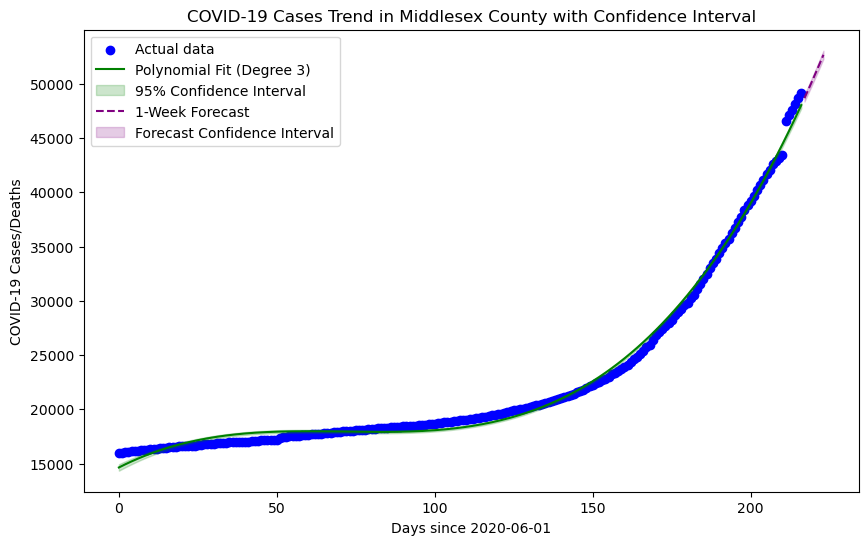

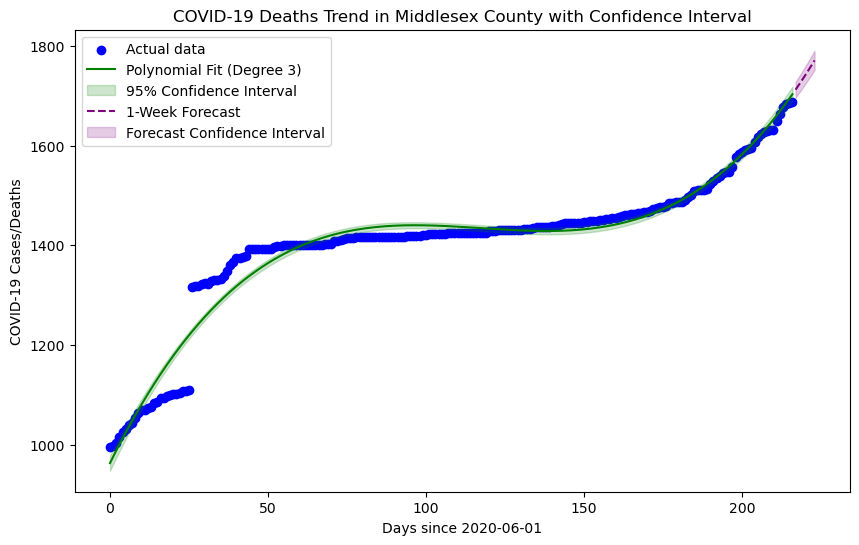

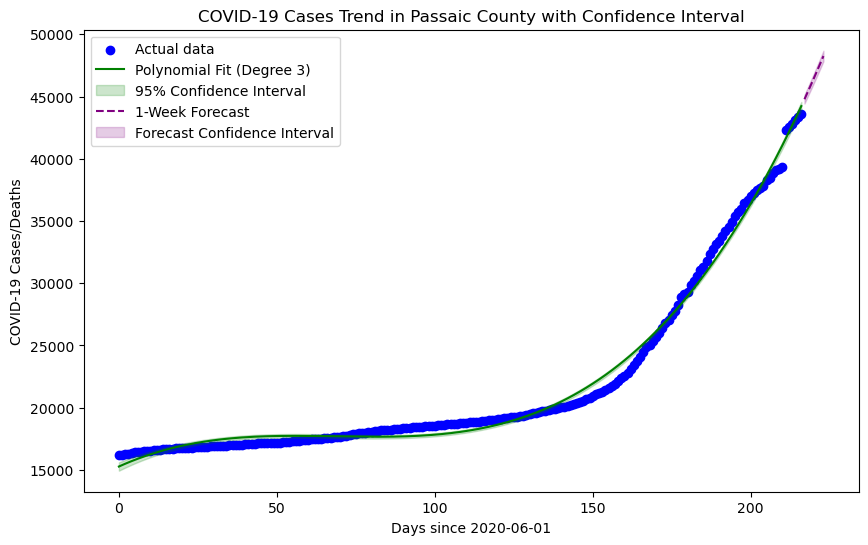

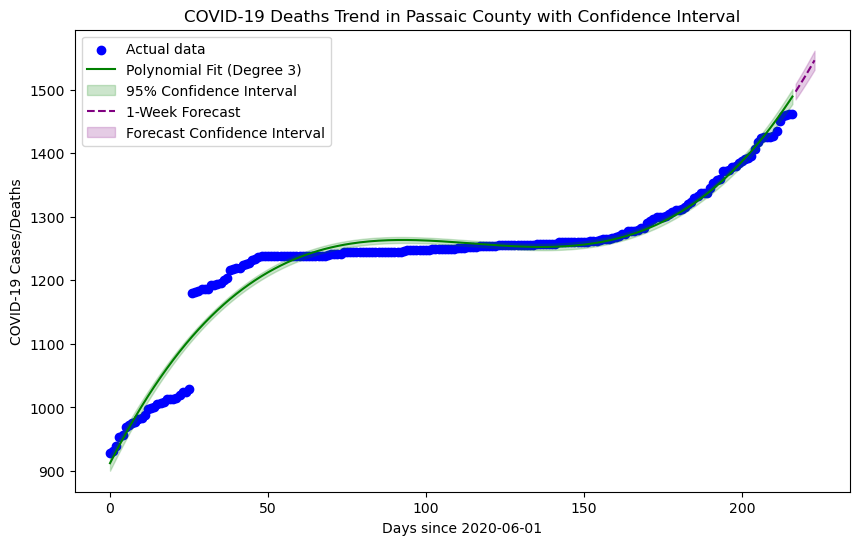

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

# function to plot with confidence intervals
def plot_with_confidence_intervals(X, Y, model, degree, title):
    # fit polynomial model
    poly = PolynomialFeatures(degree = degree)
    X_poly = poly.fit_transform(X)
    model.fit(X_poly, Y)
    
    # making predictions
    predictions = model.predict(X_poly)
    
    # confidence interval using statsmodels
    X_sm = sm.add_constant(X_poly)
    model_sm = sm.OLS(Y, X_sm).fit()
    predictions_sm = model_sm.get_prediction(X_sm)
    ci = predictions_sm.conf_int()

    # 1-week future forecast
    future_days = np.array(range(X[-1][0] + 1, X[-1][0] + 8)).reshape(-1, 1)
    future_X_poly = poly.transform(future_days)
    future_predictions = model.predict(future_X_poly)

    # extend confidence interval for the future days
    future_X_sm = sm.add_constant(future_X_poly)
    future_predictions_sm = model_sm.get_prediction(future_X_sm)
    future_ci = future_predictions_sm.conf_int()
    
    # plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y, color="blue", label="Actual data")
    plt.plot(X, predictions, color="green", label=f"Polynomial Fit (Degree {degree})")
    plt.fill_between(X.flatten(), ci[:, 0], ci[:, 1], color="green", alpha=0.2, label="95% Confidence Interval")

    # plotting the forecasted values
    plt.plot(future_days, future_predictions, color="purple", linestyle='--', label="1-Week Forecast")
    plt.fill_between(future_days.flatten(), future_ci[:, 0], future_ci[:, 1], color="purple", alpha=0.2, label="Forecast Confidence Interval")
    
    plt.xlabel("Days since 2020-06-01")
    plt.ylabel("COVID-19 Cases/Deaths")
    plt.title(title)
    plt.legend()
    plt.show()

# apply the function to each county for cases and deaths
for county in top_counties:
    # cases
    county_data = nj_cases[nj_cases['County Name'] == county]
    X = county_data['days_since_start'].values.reshape(-1, 1)
    Y = county_data['count'].values
    model = LinearRegression()
    plot_with_confidence_intervals(X, Y, model, degree=3, title=f"COVID-19 Cases Trend in {county}with Confidence Interval")
    
    # deaths
    county_data = nj_deaths[nj_deaths['County Name'] == county]
    X = county_data['days_since_start'].values.reshape(-1, 1)
    Y = county_data['count'].values
    plot_with_confidence_intervals(X, Y, model, degree=3, title=f"COVID-19 Deaths Trend in {county}with Confidence Interval")

#### Graph Analysis:

As we can see for each graph, based on the top five counties of New Jersey at most risk, there is a continued increase for the predicted week after the plotted data. The one-week prediction path for each graph also includes the forecasted confidence interval for possible errors in the prediction.

Considering the actual data of COVID-19, the predictions for each graph is very accurate as to the actual cases and deaths - continually increasing.